# k-Means
## Intra-cluster cohesion

An important property of the k-Means algorithm is that at every step $t$ it greedily increases the _intra-cluster cohesion_ by minimising the least squared distance between each point and its centroid (also called _inertia_, or the $J$ criterion) defined as:

$$
J(C^t, \mu^t) = \sum_{i=1}^n\|x_i-\mu_{C^t(x_i)}^t\|^2 = \sum_{i=1}^n(x_i-\mu_{C^t(x_i)}^t) \cdot (x_i-\mu_{C^t(x_i)}^t)
$$

where:
* $C^t=(C_1^t, C_2^t,...,C_K^t)$ is the set of all clusters (also called the K-partition) at step $t$;
* $\mu^t=(\mu_1^t, \mu_2^t,...,\mu_K^t)$ is the set of centroids at step $t$;
* $C^t(x_i)$ is the cluster corresponding to element $x_i$ at step $t$;
* the "$\cdot$" operator is the scalar multiplication for vectors in $\mathbb{R}^d$;
* "$\|\|$" denotes the Euclidean norm.

The `sklearn` implementation of the algorithm provides this metric through the `inertia_` parameter. We can confirm its value by running the algorithm on a simple dataset:

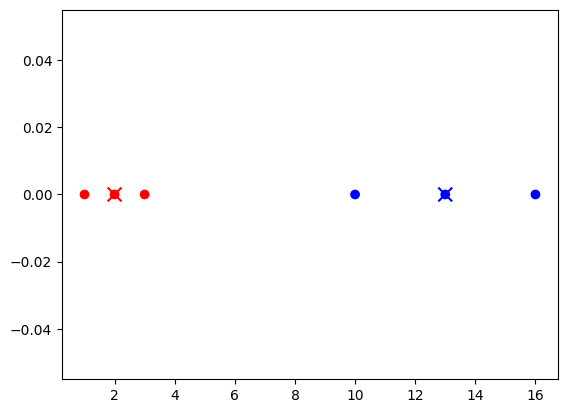

Intra-cluster cohesion (i.e. inertia): 20.0


In [1]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create a simple dataset
d = pd.DataFrame({
    'X': [1, 2, 3, 10, 13, 16],
})

c = ListedColormap(['red', 'green', 'blue'])

# Find clusters
km = KMeans(n_clusters=2, random_state=1, n_init=10)
clusters = km.fit_predict(d)

# Take the centroids
x_centroids = km.cluster_centers_[:,0]

# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.show()
print("Intra-cluster cohesion (i.e. inertia):", km.inertia_)

Since this is a simple dataset, we can easily calculate the metric independently. For the blue cluster, the sum of the squared distances between each point and the centroid is $1^2+0^2+1^2=2$. For the red cluster, the sum is $3^2+0^2+3^2=18$. Adding up the two clusters, we have $2+18=20$, as expected.

---
**Give it a try!**

Using the functions imported below as well as the `vector1[vector2]` indexing in numpy, calculate the J criterion in a single (and short) line of code:

In [2]:
from numpy.linalg import norm
from numpy import square, sum

d = pd.DataFrame({'X': [1, 2, 3, 10, 13, 16]})
km = KMeans(n_clusters=2, random_state=1, n_init=10).fit(d)
centroids = km.cluster_centers_
clusters = km.predict(d)

# Your code here

Expected result: 20.0

---

## Improving the starting centroids: k-means++

In the simplest version, the k-means algorithm will choose the initial centroids at random from the existing points in the dataset. This means that there is a chance that some of the natural clusters will start without a centroid, risking to not be correctly identified by the algorithm, while some of the centroids start very close to each other.

To alleviate this, Arthur and Vassilvitskii proposed in 2007 a method for choosing the starting centroids that aims to spread them as much as possible:
1. choose the first centroid at random from the data points;
1. until all centroids are chosen:
  1. calculate the distance between each data point and the nearest centroid;
  1. choose the next centroid from the data points with a probability proportional to that distance.
  
The `sklearn` implementation allows us to switch between the _random_ initialisation and the _k-means++_ initialisation using the `init` parameter (the same parameter that allows us to directly specify the starting centroids). Even if we cannot look into the first iteration directly (because we cannot set `max_iter=0`), we can see how the centroids can end up relatively close together after the first iteration:

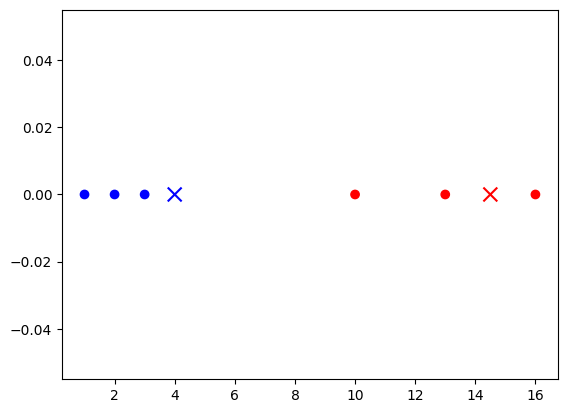

In [3]:
# Find clusters
km = KMeans(init='random', n_clusters=2, random_state=4, max_iter=1, n_init=1, algorithm='lloyd')
clusters = km.fit_predict(d)

# Take the centroids
x_centroids = km.cluster_centers_[:,0]

# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.show()

The above configuration is very improbable with _k-means++_, where most of the configurations after one iteration look like this:

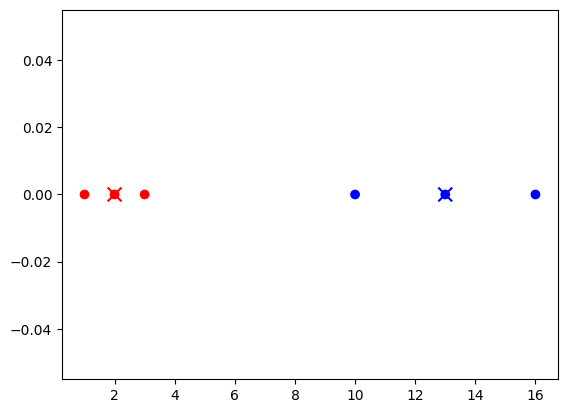

In [4]:
# Find clusters
km = KMeans(init='k-means++', n_clusters=2, random_state=1, max_iter=1, n_init=1, algorithm='lloyd')
clusters = km.fit_predict(d)

# Take the centroids
x_centroids = km.cluster_centers_[:,0]

# Scatter plot including centroids
plt.scatter(d, np.zeros_like(d), c=clusters, cmap=c)
plt.scatter(x_centroids, np.zeros_like(x_centroids), s=100, marker='x', 
            c=range(len(x_centroids)), cmap=c)
plt.show()

## Finding the number of clusters with the elbow method

An important limitation of k-means is that the number of clusters must be known beforehand. Unlike with hierarchical clustering, where we could analyse the dendrogram to simply choose the best number of clusters after a single run, k-means requires multiple runs to find the best $k$.

One way to do this is to plot the least squared distance (also known as the $J$ criterion, provided in the `inertia_` attribute) as a line chart for each viable value of $k$ and try to find the "elbow" of the plot, that is to find the value of $k$ where the cohesion stops improving significantly and reaches a plateau. Note that if the number of clusters reaches the number of instances, the least sequared distance will be 0, since each point will be identical to its centroid, this is why the minimal value of $J$ is not relevant.

The elbow can be sometimes difficult to identify, if the clusters are not well defined.

For instance, if this was the plot for the value of $J$:

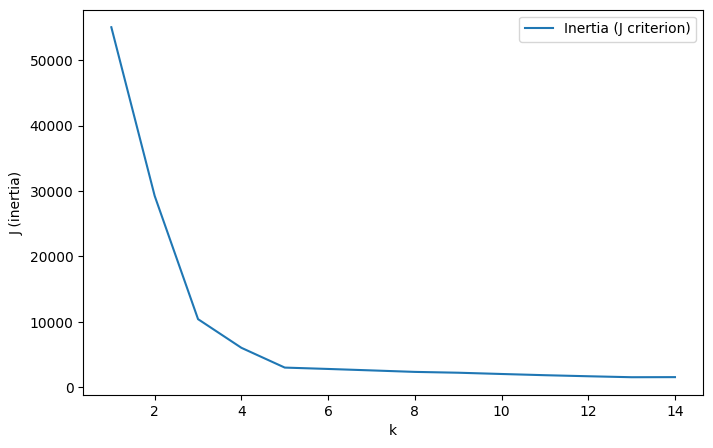

In [5]:

J = [55037, 29241, 10398, 6015, 2991, 2783, 
     2560, 2333, 2206, 2013, 1827, 1666, 1518, 1532]
k_range=range(1, 1+len(J))
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(k_range, J, label='Inertia (J criterion)')
plt.legend()
plt.xlabel("k")
plt.ylabel("J (inertia)")
plt.show()

we can see that after $k=5$, $J$ reaches a plateau, so in this the dataset appears to have 5 fairly distinct clusters. However, another good candidate here would be 3, where another "break" is visible in the graph, so it appears that the dataset consists of 3 larger clusters which can be roughly broken into 5 smaller ones. Indeed, if we plot the data behind this graph, we can confirm this is the case:

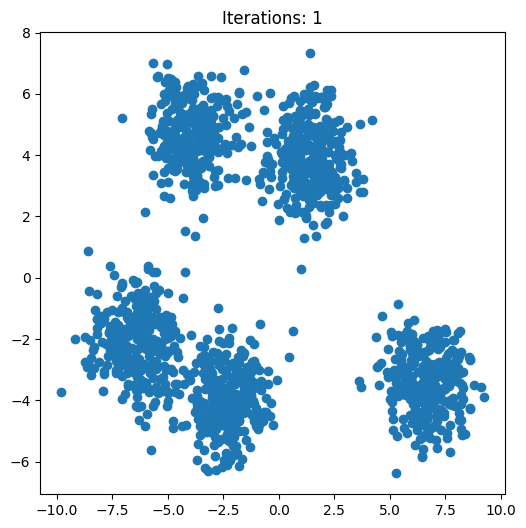

In [6]:
from sklearn.datasets import make_blobs
n_samples = 1500
random_state = 160
X, y = make_blobs(n_samples=n_samples, centers=5, random_state=random_state)
d = pd.DataFrame(X, columns=['X1', 'X2'])
# Plot clusters
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(d['X1'], d['X2'])
plt.title(f'Iterations: {km.n_iter_}')
plt.show()